In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import torch
import warnings
warnings.filterwarnings('ignore')
torch.set_default_tensor_type(torch.DoubleTensor)
import random
import math
import torch.nn as nn
from torch.nn import functional as F
from collections import defaultdict
import torch
from mingpt.utils import CfgNode as CN
from tqdm.auto import tqdm
from sklearn.metrics import *
torch.set_default_tensor_type(torch.DoubleTensor)
import geomloss
import scanpy as sc
from torch.utils.data import (DataLoader, Dataset)
import numpy as np
import os

def label_transfer(ref, query, label):
    from sklearn.neighbors import KNeighborsClassifier

    X_train = ref
    y_train = label
    X_test = query

    knn = KNeighborsClassifier().fit(X_train, y_train)
    y_test = knn.predict(X_test)

    return y_test
def run_SVM(x_train, y_train, x_test, kernel="rbf", seed=2021):
    if "rbf" == kernel:
        from sklearn.svm import SVC
        model = SVC(decision_function_shape="ovr", kernel=kernel, random_state=seed)
        # model = SVC(decision_function_shape="ovo", kernel=kernel, random_state=seed)
    elif "linear" == kernel:
        from sklearn.svm import LinearSVC
        model = LinearSVC(multi_class='ovr', random_state=seed)

    ## fit model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

def same_seeds(seed):
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


same_seeds(2023)


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)
        # print("B, T, C",B, T, C)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        # print("q, k, v",q, k, v)
        q = F.relu(q)
        k = F.relu(k)
        v = F.relu(v)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        att = F.relu(att)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc=nn.Linear(config.n_embd, 2 * config.n_embd),
            c_proj=nn.Linear(2 * config.n_embd, config.n_embd),
            act=nn.ReLU(),
            dropout=nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))  # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class scDataSet(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        data = torch.from_numpy(self.data)
        label = torch.from_numpy(self.label)

        x = torch.tensor(data[idx])
        y = torch.tensor(label[idx])
        return x, y

class GPT(nn.Module):

    @staticmethod
    def get_default_config():
        C = CN()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd = None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        C.entreg = .1
        C.p = 2
        C.h = 2
        C.loss1 = 50
        C.mod2_dim = 134
        return C

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size
        self.conf = config
        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        assert type_given ^ params_given  # exactly one of these (XOR)
        if type_given:
            # translate from model_type to detailed configuration
            config.merge_from_dict({
                                       # names follow the huggingface naming conventions
                                       # GPT-1
                                       'openai-gpt': dict(n_layer=12, n_head=12, n_embd=768),  # 117M params
                                       # GPT-2 configs
                                       'gpt2': dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                                       'gpt2-medium': dict(n_layer=24, n_head=16, n_embd=1024),  # 350M params
                                       'gpt2-large': dict(n_layer=36, n_head=20, n_embd=1280),  # 774M params
                                       'gpt2-xl': dict(n_layer=48, n_head=25, n_embd=1600),  # 1558M params
                                       # Gophers
                                       'gopher-44m': dict(n_layer=8, n_head=16, n_embd=512),
                                       # (there are a number more...)
                                       # I made these tiny models up
                                       'gpt-mini': dict(n_layer=6, n_head=6, n_embd=192),
                                       'gpt-micro': dict(n_layer=4, n_head=4, n_embd=128),
                                       'gpt-nano': dict(n_layer=1, n_head=config.h, n_embd=config.n_embd),
                                   }[config.model_type])
        print("config.vocab_size, config.n_embd", config.vocab_size, config.n_embd)
        self.pro = nn.Linear(config.vocab_size, config.n_embd)
        self.transformer = nn.ModuleDict(dict(
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.embd_pdrop),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=nn.LayerNorm(config.n_embd),
        ))  # config.n_embd*config.block_size
        # self.lm_head = nn.Linear(config.n_embd, config.mod2_dim, bias=False)
        self.lm_head = nn.Linear(config.n_embd, config.mod2_dim)  # , bias=False
        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params / 1e6,))

    def cross_mod(self, mod1, mod2=None):
        idx = torch.tensor(mod1, dtype=torch.double)
        device = idx.device
        # idx = self.pro(idx)
        # idx= F.relu(idx)

        b, t, v = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)  # shape (1, t)
        num_cls = int(self.conf.block_size/2)
        cls1 = torch.zeros(num_cls).long()
        cls2 = torch.ones(num_cls).long()
        cls = torch.cat((cls1, cls2), dim=0)

        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (1, t, n_embd)
        cls_emb = self.transformer.wpe(cls) # + cls_emb

        x = self.transformer.drop(idx + pos_emb + cls_emb)
        for block in self.transformer.h:
            x = F.relu(x)
            x = block(x)
        x = F.relu(x)
        x = self.transformer.ln_f(x)
        x = F.relu(x)
        x = torch.mean(x, dim=1)
        emb = x
        logits = self.lm_head(x)
        mod_logits = F.relu(logits)

        # if we are given some desired targets also calculate the loss
        loss = None
        # criterion = nn.CrossEntropyLoss()

        if mod2 is not None:
            targets = torch.tensor(mod2, dtype=torch.double)
            loss1 = F.mse_loss(mod_logits, targets) ** 0.5
            loss = loss1  # loss1 #+ loss2
        return loss, emb,mod_logits

    def forward(self, X, Y):
        loss1, emb_mod,mod1_logits2 = self.cross_mod(X, Y)

        emb_mod1 = emb_mod[:,:int(emb_mod.shape[1] / 2)]
        emb_mod2 = emb_mod[:, int(emb_mod.shape[1] / 2):]
        loss3 = F.mse_loss(emb_mod1, emb_mod2) ** 0.5
        loss = loss1*self.conf.loss1 + loss3 #/ 10
        return emb_mod1, emb_mod2, loss,loss1,loss3,mod1_logits2

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear,)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn  # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params),)
        assert len(
            param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params),)

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer


from typing import Tuple
import scipy


def foscttm(
        x: np.ndarray, y: np.ndarray, **kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    if x.shape != y.shape:
        raise ValueError("Shapes do not match!")
    d = scipy.spatial.distance_matrix(x, y, **kwargs)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    return foscttm_x, foscttm_y

class Trainer:

    @staticmethod
    def get_default_config():
        C = CN()
        # device to train on
        C.device = 'cpu'
        # dataloder parameters
        C.num_workers = 1
        # optimizer parameters
        C.epoch = 100
        C.batch_size = 64
        C.learning_rate = 3e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1  # only applied on matmul weights
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.callbacks = defaultdict(list)
        # determine the device we'll train on
        if config.device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = config.device
        self.model = self.model.to(self.device)
        print("running on device", self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def run(self):
        model, config = self.model, self.config

        # setup the optimizer
        self.optimizer = model.configure_optimizers(config)

        train_loader = DataLoader(self.train_dataset, batch_size=config.batch_size, shuffle=False,
                                  pin_memory=True)

        model.train()
        n_epochs = config.epoch
        for epoch in range(n_epochs):

            train_loss = []
            train_loss1 = []
            train_loss3 = []
            emb_mod1s = []
            emb_mod2s = []
            mod1_logits2s = []
            mod2_logits1s = []
            for batch in tqdm(train_loader):
                X, Y, = batch
                emb_mod1, emb_mod2, self.loss,self.loss1,self.loss3, mod1_logits2 = model(X, Y)
                model.zero_grad(set_to_none=True)
                self.loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                self.optimizer.step()
                train_loss.append(self.loss.item())
                train_loss1.append(self.loss1.item())
                train_loss3.append(self.loss3.item())

                emb_mod1s.extend(emb_mod1.detach().numpy())
                emb_mod2s.extend(emb_mod2.detach().numpy())

                mod1_logits2s.extend(mod1_logits2.detach().numpy())
                #mod2_logits1s.extend(mod2_logits1.detach().numpy())


            train_loss = sum(train_loss) / len(train_loss)
            train_loss1 = sum(train_loss1) / len(train_loss1)
            train_loss3 = sum(train_loss3) / len(train_loss3)

            print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f},"
                  f"loss1 = {train_loss1:.5f},"
                  f"loss3 = {train_loss3:.5f},")

        emb_mod1s = np.asarray(emb_mod1s)
        emb_mod2s = np.asarray(emb_mod2s)

        mod1_logits2s = np.asarray(mod1_logits2s)
        #mod2_logits1s = np.asarray(mod2_logits1s)

        return emb_mod1s, emb_mod2s, mod1_logits2s#, mod2_logits1s

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)


def GeneEmbeding(X, gap):
    # gap = 10240
    single_cell_list = []
    for single_cell in X:
        feature = []
        length = len(single_cell)
        for k in range(0, length, gap):
            if (k + gap > length):
                a = single_cell[length - gap:length]
            else:
                a = single_cell[k:k + gap]
            feature.append(a)
        feature = np.asarray(feature)
        single_cell_list.append(feature)

    single_cell_list = np.asarray(single_cell_list)
    print("single_cell_list.shape", single_cell_list.shape)
    return single_cell_list

def getXY2(mod_paths, mod_names, gap):
    # step1: 获得两种模态数据并且进行预处理
    adata_mod1 = sc.read_h5ad(mod_paths[0] + mod_names[0])
    adata_mod1.var_names_make_unique()
    adata_mod1.obs['domain_id'] = 0
    sc.pp.normalize_total(adata_mod1)
    sc.pp.log1p(adata_mod1)

    adata_mod2 = sc.read_h5ad(mod_paths[1] + mod_names[1])
    adata_mod2.var_names_make_unique()
    adata_mod2.obs['domain_id'] = 1
    sc.pp.normalize_total(adata_mod2)
    sc.pp.log1p(adata_mod2)


    data_cm = adata_mod1.concatenate(adata_mod2)
    sc.pp.highly_variable_genes(data_cm, n_top_genes=2000)
    data_cm = data_cm[:, data_cm.var['highly_variable']]
    #sc.pp.scale(data_cm)
    import uniport as up
    adata_mod1 = data_cm[:len(adata_mod1)]
    adata_mod2 = data_cm[len(adata_mod1):]

    num_cell1 = adata_mod1.shape[1]
    num_cell2 = adata_mod2.shape[1]

    features = min(num_cell1, num_cell2)
    comp = 100
    print("features", features)
    if (features < 40):
        comp = 20
    elif (features < 50):
        comp = 40
    elif (50 < features < 100):
        comp = 50
    elif (100 < features < 200):
        comp = 100
    elif (200 < features < 300):
        comp = 200
    print("comp", comp)
    sc.tl.pca(adata_mod1, n_comps=comp, svd_solver="auto")
    sc.tl.pca(adata_mod2, n_comps=comp, svd_solver="auto")

    X1 = adata_mod1.obsm['X_pca']  # .todense()
    X2 = adata_mod2.obsm['X_pca']  # .todense()

    if not isinstance(X1, np.ndarray):
        X1 = X1.todense()

    if not isinstance(X2, np.ndarray):
        X2 = X2.todense()

    X1 = np.asarray(X1)
    X2 = np.asarray(X2)
    Y1 = np.concatenate((X1,X2),axis=1)

    X1 = GeneEmbeding(X1, gap)
    X2 = GeneEmbeding(X2, gap)

    X1 = np.concatenate((X1,X2),axis=1)

    # train_labels= []
    # test_labels= []

    train_labels = adata_mod1.obs["cell_type"].values
    test_labels =  adata_mod2.obs["cell_type"].values

    return X1, train_labels, Y1, test_labels,adata_mod1,adata_mod2  # single_cell_list, labelss, cell_types

##ADT
def getXY3(mod_paths, mod_names, gap,batch):
    # step1: 获得两种模态数据并且进行预处理
    adata_mod1 = sc.read_h5ad(mod_paths[0] + mod_names[0])
    adata_mod1.var_names_make_unique()
    adata_mod1.obs['domain_id'] = 0
    sc.pp.normalize_total(adata_mod1)
    sc.pp.log1p(adata_mod1)
    sc.pp.highly_variable_genes(adata_mod1, n_top_genes=2000)
    adata_mod1 = adata_mod1[:, adata_mod1.var['highly_variable']]

    adata_mod2 = sc.read_h5ad(mod_paths[1] + mod_names[1])
    adata_mod2.var_names_make_unique()
    adata_mod2.obs['domain_id'] = 1
    # sc.pp.normalize_total(adata_mod2)
    # sc.pp.log1p(adata_mod2)
    from muon import prot as pt
#     if(batch == 'a')
#         pt.pp.clr(adata_mod2)

    num_cell1 = adata_mod1.shape[1]
    num_cell2 = adata_mod2.shape[1]

    features = min(num_cell1, num_cell2)
    comp = 100
    h = 4
    print("features", features)
    if (features < 40):
        comp = 30
        gap = 16
        h = 4
    elif (features < 50):
        comp = 40
        gap = 16
        h = 4

    elif (50 < features < 100):
        comp = 50
        gap = 32
        h = 8

    elif (100 < features < 200):
        comp = 100
        gap = 64
        h = 16
    elif (200 < features < 300):
        comp = 200
        gap = 128
        h = 32
    comp = 216
    gap = 192
    h = 32

    print("comp", comp)
    print("h", h)
    sc.tl.pca(adata_mod1, n_comps=comp, svd_solver="auto")
    sc.tl.pca(adata_mod2, n_comps=comp, svd_solver="auto")

    X1 = adata_mod1.obsm['X_pca']  # .todense()
    X2 = adata_mod2.obsm['X_pca']  # .todense()

    if not isinstance(X1, np.ndarray):
        X1 = X1.todense()

    if not isinstance(X2, np.ndarray):
        X2 = X2.todense()

    X1 = np.asarray(X1)
    X2 = np.asarray(X2)
    Y1 = np.concatenate((X1,X2),axis=1)

    X1 = GeneEmbeding(X1, gap)
    X2 = GeneEmbeding(X2, gap)

    X1 = np.concatenate((X1,X2),axis=1)

    # train_labels= []
    # test_labels= []

    train_labels = adata_mod1.obs["cell_type"].values
    test_labels =  adata_mod2.obs["cell_type"].values

#     train_labels = adata_mod1.obs["celltype.l1"].values
#     test_labels =  adata_mod2.obs["celltype.l1"].values

    adata_mod1.obs['batch'] = batch
    adata_mod2.obs['batch'] = batch
    return X1, train_labels, Y1, test_labels,adata_mod1,adata_mod2,h  # single_cell_list, labelss, cell_types

import time
gap = 128
data_name = "asapseq_control"
test_ADT = "../../../Dataset/ADT_GEX/"+ data_name +"/"
test_GEX = "../../../Dataset/ADT_GEX/"+ data_name +"/"

test_paths = [test_GEX, test_ADT]
test_names = [data_name + "_rna.h5ad",data_name + "_adt.h5ad",]

X1_1, train_labels_1, Y1_1, test_labels_1,adata_mod1_1,adata_mod2_1,h_1 = getXY3(test_paths, test_names, gap,"a")

data_name = "citeseq_control"
test_ADT = "../../../Dataset/ADT_GEX/"+ data_name +"/"
test_GEX = "../../../Dataset/ADT_GEX/"+ data_name +"/"

test_paths = [test_GEX, test_ADT]
test_names = [data_name + "_rna.h5ad",data_name + "_adt.h5ad",]
X1_2, train_labels_2, Y1_2, test_labels_2,adata_mod1_2,adata_mod2_2,h_2 = getXY3(test_paths, test_names, gap,"b")


print("X1_1.shape",X1_1.shape,"Y1_1.shape",Y1_1.shape)
print("X1_2.shape",X1_2.shape,"Y1_2.shape",Y1_2.shape)

h = min(h_1,h_2)
X1 = np.concatenate((X1_1,X1_2),axis=0)
Y1 = np.concatenate((Y1_1,Y1_2),axis=0)
print("train_mod1.shape", X1.shape)
print("train_mod2.shape", Y1.shape)

start = time.time()

a, b, c = X1.shape
print("a,b,c,", a, b, c)
train_dataset = scDataSet(data = X1, label = Y1)

model_name = "integration_end_v4"

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = c
model_config.block_size = b
model_config.n_embd = c
model_config.embd_pdrop = 0.0
model_config.resid_pdrop = 0.0
model_config.attn_pdrop = 0.0
model_config.loss1 = 100
model_config.h = h
model_config.mod2_dim = Y1.shape[1]
print("model_config.mod2_dim ", model_config.mod2_dim)
print("model_config.vocab_size", model_config.vocab_size)
model = GPT(model_config)


train_config = Trainer.get_default_config()
train_config.epoch = 50
train_config.learning_rate = 1e-4
train_config.batch_size = 32  # 10240
trainer = Trainer(train_config, model, train_dataset)

log_dir = "log/" + str(model_name) + "/" + data_name + "/"
if (not os.path.isdir(log_dir)):
    os.makedirs(log_dir)

emb_mod1s1, emb_mod2s1,mod1_logits2s, = trainer.run() #mod2_logits1s
print("emb_mod1s.shape", emb_mod1s1.shape)
print("emb_mod2s.shape", emb_mod2s1.shape)

# emb_mod = np.concatenate((emb_mod1s1,emb_mod2s1),axis=1)
# emb_mod1s = emb_mod[:len(train_labels_1)]
# emb_mod2s = emb_mod[len(train_labels_1):]

end = time.time()
all_time = end - start

#19.33

features 227
comp 216
h 32
single_cell_list.shape (4502, 2, 192)
single_cell_list.shape (4502, 2, 192)
features 227
comp 216
h 32
single_cell_list.shape (4644, 2, 192)
single_cell_list.shape (4644, 2, 192)
X1_1.shape (4502, 4, 192) Y1_1.shape (4502, 432)
X1_2.shape (4644, 4, 192) Y1_2.shape (4644, 432)
train_mod1.shape (9146, 4, 192)
train_mod2.shape (9146, 432)
a,b,c, 9146 4 192
model_config.mod2_dim  432
model_config.vocab_size 192
config.vocab_size, config.n_embd 192 192
number of parameters: 0.30M
running on device cpu


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 001/050 ] loss = 78.54946,loss1 = 0.78014,loss3 = 0.53559,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 002/050 ] loss = 77.98384,loss1 = 0.77631,loss3 = 0.35333,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 003/050 ] loss = 77.58318,loss1 = 0.77287,loss3 = 0.29591,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 004/050 ] loss = 77.18772,loss1 = 0.76895,loss3 = 0.29247,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 005/050 ] loss = 76.83157,loss1 = 0.76537,loss3 = 0.29481,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 006/050 ] loss = 76.41311,loss1 = 0.76111,loss3 = 0.30197,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 007/050 ] loss = 76.03841,loss1 = 0.75730,loss3 = 0.30829,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 008/050 ] loss = 75.69540,loss1 = 0.75386,loss3 = 0.30977,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 009/050 ] loss = 75.37320,loss1 = 0.75062,loss3 = 0.31160,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 010/050 ] loss = 75.07181,loss1 = 0.74756,loss3 = 0.31608,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 011/050 ] loss = 74.79030,loss1 = 0.74468,loss3 = 0.32216,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 012/050 ] loss = 74.51908,loss1 = 0.74191,loss3 = 0.32832,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 013/050 ] loss = 74.27387,loss1 = 0.73939,loss3 = 0.33494,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 014/050 ] loss = 74.04307,loss1 = 0.73703,loss3 = 0.34031,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 015/050 ] loss = 73.81739,loss1 = 0.73472,loss3 = 0.34573,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 016/050 ] loss = 73.35123,loss1 = 0.72966,loss3 = 0.38479,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 017/050 ] loss = 72.44875,loss1 = 0.72019,loss3 = 0.42932,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 018/050 ] loss = 71.75792,loss1 = 0.71332,loss3 = 0.42593,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 019/050 ] loss = 71.20424,loss1 = 0.70783,loss3 = 0.42144,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 020/050 ] loss = 70.77334,loss1 = 0.70354,loss3 = 0.41887,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 021/050 ] loss = 70.43881,loss1 = 0.70021,loss3 = 0.41767,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 022/050 ] loss = 70.16759,loss1 = 0.69750,loss3 = 0.41808,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 023/050 ] loss = 69.93459,loss1 = 0.69515,loss3 = 0.42008,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 024/050 ] loss = 69.72735,loss1 = 0.69304,loss3 = 0.42349,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 025/050 ] loss = 69.53293,loss1 = 0.69106,loss3 = 0.42729,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 026/050 ] loss = 69.34918,loss1 = 0.68918,loss3 = 0.43135,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 027/050 ] loss = 69.17129,loss1 = 0.68735,loss3 = 0.43605,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 028/050 ] loss = 68.99938,loss1 = 0.68558,loss3 = 0.44097,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 029/050 ] loss = 68.83372,loss1 = 0.68388,loss3 = 0.44572,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 030/050 ] loss = 68.67656,loss1 = 0.68226,loss3 = 0.45035,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 031/050 ] loss = 68.51608,loss1 = 0.68060,loss3 = 0.45568,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 032/050 ] loss = 68.36763,loss1 = 0.67907,loss3 = 0.46043,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 033/050 ] loss = 68.22307,loss1 = 0.67758,loss3 = 0.46507,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 034/050 ] loss = 68.07908,loss1 = 0.67610,loss3 = 0.46914,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 035/050 ] loss = 67.94100,loss1 = 0.67468,loss3 = 0.47303,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 036/050 ] loss = 67.80501,loss1 = 0.67328,loss3 = 0.47673,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 037/050 ] loss = 67.67975,loss1 = 0.67199,loss3 = 0.48062,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 038/050 ] loss = 67.55483,loss1 = 0.67070,loss3 = 0.48495,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 039/050 ] loss = 67.44036,loss1 = 0.66951,loss3 = 0.48921,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 040/050 ] loss = 67.32534,loss1 = 0.66832,loss3 = 0.49361,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 041/050 ] loss = 67.21320,loss1 = 0.66715,loss3 = 0.49806,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 042/050 ] loss = 66.96588,loss1 = 0.66457,loss3 = 0.50932,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 043/050 ] loss = 66.35610,loss1 = 0.65807,loss3 = 0.54874,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 044/050 ] loss = 65.78264,loss1 = 0.65219,loss3 = 0.56350,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 045/050 ] loss = 65.33253,loss1 = 0.64775,loss3 = 0.55712,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 046/050 ] loss = 65.02126,loss1 = 0.64472,loss3 = 0.54898,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 047/050 ] loss = 64.79218,loss1 = 0.64249,loss3 = 0.54339,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 048/050 ] loss = 64.61889,loss1 = 0.64079,loss3 = 0.53984,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 049/050 ] loss = 64.48410,loss1 = 0.63946,loss3 = 0.53831,


  0%|          | 0/286 [00:00<?, ?it/s]

[ Train | 050/050 ] loss = 64.37016,loss1 = 0.63833,loss3 = 0.53745,
emb_mod1s.shape (9146, 96)
emb_mod2s.shape (9146, 96)


In [2]:
train_labels = np.concatenate((train_labels_1,train_labels_2),axis=0)
test_labels = np.concatenate((test_labels_1,test_labels_2),axis=0)
print(train_labels.shape)
print(test_labels.shape)

kernel = 'linear'
preds = run_SVM(emb_mod1s1, train_labels, emb_mod2s1, kernel=kernel)
svm_acc = accuracy_score(test_labels, preds)
svm_f1 = f1_score(test_labels, preds, average='macro')
print("svm_acc", svm_acc, "svm_f1", svm_f1)

y_test = label_transfer(emb_mod1s1,emb_mod2s1,train_labels)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score
knn_f1_micro = f1_score(test_labels, y_test, average='micro')
knn_f1_macro = f1_score(test_labels, y_test, average='macro')
knn_acc = accuracy_score(test_labels, y_test)
knn_ARI = adjusted_rand_score(test_labels, y_test)
knn_nmi = normalized_mutual_info_score(test_labels, y_test)
print("knn_f1_micro", knn_f1_micro, "knn_f1_macro", knn_f1_macro,"knn_acc", knn_acc, "knn_f1_macro", knn_f1_macro)
#



(9146,)
(9146,)
svm_acc 0.7376995407828559 svm_f1 0.6898652250216084
knn_f1_micro 0.7267657992565054 knn_f1_macro 0.6766958833339178 knn_acc 0.7267657992565055 knn_f1_macro 0.6766958833339178


In [3]:
adata_mod1_1
emb_mod1s1.shape

(9146, 96)

In [4]:
np.save("emb_mod1s1.npy",emb_mod1s1)
np.save("emb_mod2s1.npy",emb_mod2s1)

In [5]:
a1 = emb_mod1s1[:len(adata_mod1_1)]
a2 = emb_mod2s1[:len(adata_mod2_1)]
b1 = emb_mod1s1[len(adata_mod1_1):]
b2 = emb_mod2s1[len(adata_mod2_1):]



In [6]:
# import ot #ot.da.EMDTransport()  ot.da.SinkhornTransport(reg_e=1e-1)

# ot_sinkhorn_un = ot.da.EMDTransport()
# ot_sinkhorn_un.fit(Xs=a1, Xt=b1)
# a11 = ot_sinkhorn_un.transform(Xs=a1)

# ot_sinkhorn_un = ot.da.EMDTransport()
# ot_sinkhorn_un.fit(Xs=a2, Xt=b2)
# a22 = ot_sinkhorn_un.transform(Xs=a2)

In [7]:
adata_mod1_1.obsm["X_scmGPT"] = a1
adata_mod2_1.obsm["X_scmGPT"] = a2

adata_mod1_1.obs['domain'] = "scRNA"
adata_mod2_1.obs['domain'] = "ADT"

adata_mod1 = sc.concat([adata_mod1_1,adata_mod2_1])



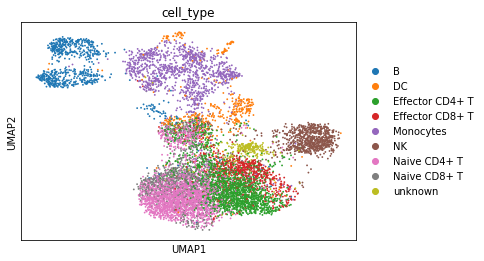

In [8]:
adata_mod1
sc.pp.neighbors(adata_mod1, use_rep="X_scmGPT", metric="cosine")
sc.tl.umap(adata_mod1)
sc.pl.umap(adata_mod1, color=["cell_type"], wspace=0.65,show=True,save= "pbmc_umap_celltype.pdf")

#,save=log_dir + "umap.pdf"

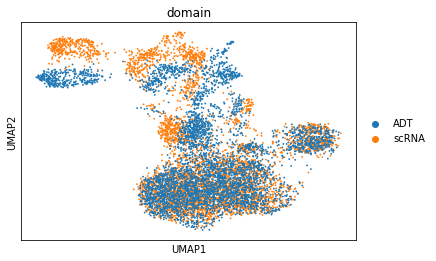

In [9]:
sc.pl.umap(adata_mod1, color=["domain"], wspace=0.65,show=True, save= "pbmc_umap_domain_.pdf") #,save=log_dir + "umap.pdf"


In [10]:
adata_mod1_2.obsm["X_scmGPT"] = b1
adata_mod2_2.obsm["X_scmGPT"] = b2

adata_mod1_2.obs['domain'] = "scRNA2"
adata_mod2_2.obs['domain'] = "ADT2"

adata_mod2 = sc.concat([adata_mod1_2,adata_mod2_2])

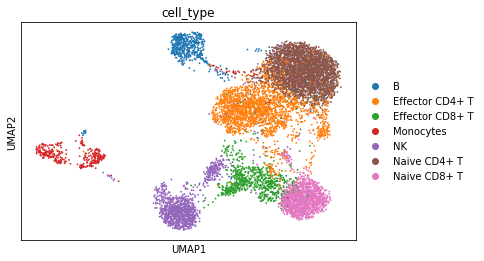

In [11]:
adata_mod2
sc.pp.neighbors(adata_mod2, use_rep="X_scmGPT", metric="cosine")
sc.tl.umap(adata_mod2)
sc.pl.umap(adata_mod2, color=["cell_type"], wspace=0.65,show=True,save= "pbmc_5p_umap_celltype.l3.pdf") 
#,save=log_dir + "umap.pdf"

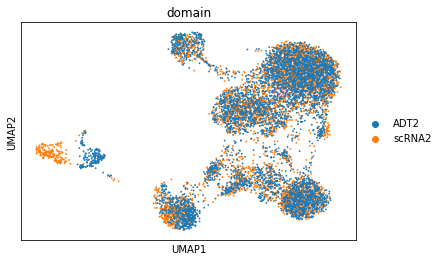

In [12]:
sc.pl.umap(adata_mod2, color=["domain"], wspace=0.65,show=True, save= "pbmc_5p_umap_domain_.pdf") #,save=log_dir + "umap.pdf"


In [13]:
combined = sc.concat([adata_mod1, adata_mod2])

In [14]:
combined
sc.pp.neighbors(combined, use_rep="X_scmGPT", metric="cosine")
sc.tl.umap(combined)
#sc.pl.umap(combined, color=["celltype.l3"], wspace=0.65,show=True, legend_loc="on data",save= "pbmc_all_umap_celltype.l3.pdf") #,save=log_dir + "umap.pdf"


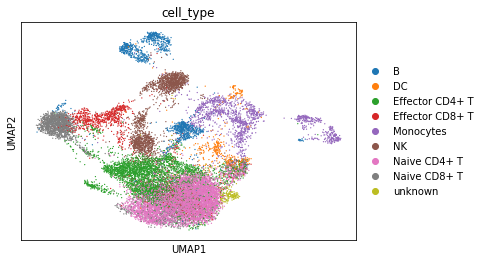

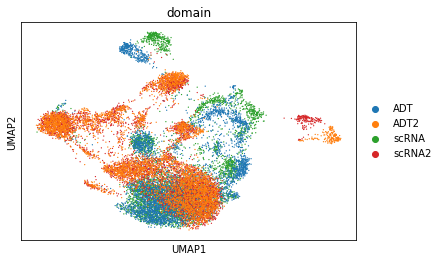

In [15]:
sc.pl.umap(combined, color=["cell_type"], wspace=0.65,show=True, save= "pbmc_all_umap_celltype.l1_.pdf") #,save=log_dir + "umap.pdf"
sc.pl.umap(combined, color=["domain"], wspace=0.65,show=True, save= "pbmc_all_umap_domain_.pdf") #,save=log_dir + "umap.pdf"


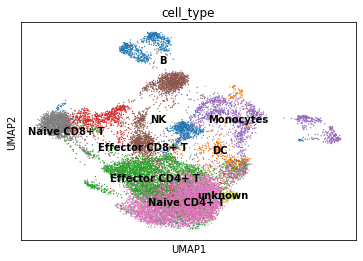

In [18]:
sc.pl.umap(combined, color=["cell_type"], wspace=0.65,show=True, save= "pbmc_all_umap_celltype.l1_ondata.pdf", legend_loc="on data") #,save=log_dir + "umap.pdf"


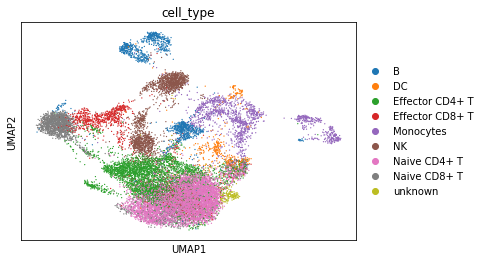

In [19]:
sc.pl.umap(combined, color=["cell_type"], wspace=0.65,show=True, save= "pbmc_all_umap_celltype.l1_.pdf") #,save=log_dir + "umap.pdf"


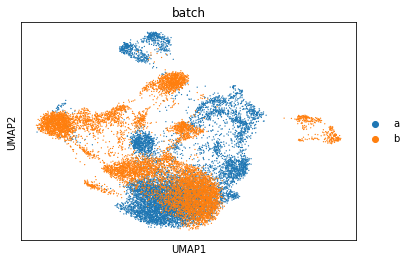

In [17]:
sc.pl.umap(combined, color=["batch"], wspace=0.65,show=True, save= "pbmc_all_umap_batch_.pdf") #,save=log_dir + "umap.pdf"
